# Project Goal

Using the emails from the Enron email dataset the goal of this project is to predict who a email composer will send emails to based off the content of the emails.  

# Methodology

As this dataset is quite large and would take a long time to process this notebook was run on an AWS server with 8 cores and 32GB of RAM.

Step one is to read in the data from all the emails stored in files into a single dataframe with the data separated by the relevant fields associated with an email (to, from, cc, bcc, body, etc.)

Step two is to remove emails that do not originate from the enron company.  This is done to remove spam and other emails that are less likely to be correlated to work.

Step three is to generate a list of all sender receiver pairs from the dataset.  Who sent email to who.  This dataframe will be the basis for where our results are built out.

Step four was to clean out some problematic addresses.  Such as clear typos of email addresses (@enron@enron.com) or email addresses that were seemingly for broadcast purposes (enron.annoucements@enron.com)

Step five count the number of emails sent for each sender receiver pair.  (Jim sent 64 emails to Bob)

Step six was to eliminate Sender Receiver pairs where the number of emails was less than 50.  This was to Make sure there was plenty of data in the train set and the test set after splitting the data.

Step seven was to run through the data and then and calculate a tf_idf centroid from the train set of emails for each sender receiver pair, and compare that centroid to each email in the test set.  If it surpassed a certain threshold we assumed it was an indication that the recipient associated with the centroid would be present in one of the to fields of the email.  If we were correct a 1 was added to the scores list.  If we were wrong a zero was added.  The mean of this list at the end of going through all test emails would be the accuracy score for that sender receiver pair.  For analysis purposes the number of emails containing the SR pair in the train and test set was also saved, as well as the number of correctly guessed emails.

Analysis below.

In [1]:
import pandas as pd
import os
import email
import time
import csv
import sys
from sklearn.model_selection import train_test_split
import math
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

#unique delim to separate columns without messing up content
DELIMETER = chr(255)

#needed because a few of the emails were too large for the default csv cell size
csv.field_size_limit(sys.maxsize)

#set paths (currently pathing for remote AWS EC2 Instance)
root = '/home/ubuntu/ssl/notebooks/'
testing_batch = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings('ignore')

In [2]:
#steps through directory and loads every email in every folder into returned df
def process_emails_into_df(origin, destination, testbool):

    #if no file already exists start the writing process
    if not os.path.isfile(destination): 

        #list for holding file paths
        list_of_files = []    

        #get the path for all the email files
        for path, subdirs, files in os.walk(origin):
            for name in files:
                list_of_files.append(os.path.join(path, name))

        email_count = len(list_of_files)
        #caluculate 1% of the number of files, used for progress report printing.
        onepcofemail = (email_count//100)

        #create dataframe to store data to be written
        emails = pd.DataFrame()
        print('Starting. {}'.format(time.strftime("%I:%M:%S")))

        #counter for testing batches
        x = 0

        #iterrate through all the files found
        for i, myfile in enumerate(list_of_files):

            #if running a testing session to break before reading all file to inspect the saved csv
            if x > 6000 and testbool: break

            #read individual email file
            with open(myfile, 'r', encoding='utf-8', errors='replace') as filepath:
                #read in the email
                message=email.message_from_string(filepath.read())

                #save the important components
                emails.loc[i,'Message-ID']=message['Message-ID']
                emails.loc[i,'from']=message['from']
                emails.loc[i,'subject']=message['subject']
                emails.loc[i,'to']=message['to']
                emails.loc[i,'cc']=message['cc']
                emails.loc[i,'bcc']=message['Bcc']
                emails.loc[i,'date']=message['date']
                emails.loc[i,'file']=message['X-FileName']

                #check that the body is one or multiple sections and save it
                if message.is_multipart():
                    string = ''
                    for payload in message.get_payload():
                        print(payload.get_payload())
                        string = string + payload.get_payload()
                        emails.loc[i,'body'] = string
                else:
                    emails.loc[i,'body'] =  message.get_payload()

            #append entry to the csv file
            with open(destination, 'a') as f:
                #if this is the first entry use the headers, if not, dont.True
                if i == 0: emails.to_csv(f, header=emails.columns, index = False, sep=DELIMETER)
                else: emails.to_csv(f, header=None, index = False, sep=DELIMETER)

            #clear the dataframe to save memory
            emails = pd.DataFrame()        

            #print statement updating progress report
            if i % onepcofemail == 0: 
                print('{}% finished. {}'.format(i//onepcofemail, time.strftime("%I:%M:%S")), end="\r")

            #itterate counter for testing batches
            x = x+1


        #process complete
        print('Done! Exported {} lines to CSV {}'.format(x, time.strftime("%I:%M:%S")))

    #prints if the file already exists and there is no need to process the individual emails into a csv
    else: 
        #open csvs of all emails
        print('**********There is already a Process CSV of All Emails, loading Now************', end="\r")
        all_emails = pd.read_csv(destination, sep=DELIMETER, engine='python')
        print('**************Processed Emails into DF Loaded From CSV, Delete File to Process Again**************')
        return all_emails        

#function that filters out non enron originating email addresses       
def filter_unwanted_senders(dataframe, new_file_dest):
    path = root + new_file_dest
    
    #check to see if file has already been processed and saved
    if not os.path.isfile(path): 
        
        #get a list of unique email senders
        unique_senders_inc_small = dataframe['from'].unique()
        
        #create an empty df to holde data
        filtered_df = pd.DataFrame(columns = dataframe.columns)
        
        #iterate through all the unique senders
        for i, sender in enumerate(unique_senders_inc_small):
            temp = dataframe[dataframe['from'] == sender]
            
            #prints progress report
            print('{}% finished filtering unwanted senders            '.format(round(i/len(
                                                                            unique_senders_inc_small)
                                                                                     *100,2)) , end="\r")

            #tests and saves senders who have enron emails
            if '@enron.com' in sender:
                filtered_df = filtered_df.append(temp, ignore_index = True)
        
        #save new list of senders
        filtered_df.to_csv(path, sep=DELIMETER, index = False)
    
    #if it has already been done don't do it again
    else: 
        print('****************Previously Filtered Senders List. Loading Old File!****************'.format(new_file_dest),
                                                                                              end="\r")
        filtered_df = pd.read_csv(path, sep=DELIMETER, engine='python')
        print('*************To Reprocess Filtered Senders Delete {}.  Loaded Old File!**************'.format(new_file_dest))
    filtered_df = filtered_df.dropna(subset = ['to', 'cc', 'bcc'], how = 'all')
    filtered_df = filtered_df.dropna(subset = ['body'])    
    return filtered_df

#makes a list of all senders and a lists all the recipients they send to in next column
def get_sender_recip_list(dataframe):
    new_file = root + 'sender_recip_df_list'
    
    if not os.path.isfile(new_file):
    
        #empty df for leading up addresses
        sender_by_recip = pd.DataFrame(columns = ['sender','recipient', 'booksize'])

        #list of unique senders
        unique_senders = dataframe['from'].unique()

        #arrays for holding values to be stored
        senders = []
        recipients = []
        addressbooksize = []

        #itterate through each unique email writer
        for i, sender in enumerate(unique_senders):

            #make a list of the samples from this itterations sender
            users_emails = dataframe[dataframe['from'] == sender]

            all_recips = users_emails['to'].tolist() + users_emails['cc'].tolist() + users_emails['bcc'].tolist() 

            if '<' in sender:
                sender = re.search('<.(.*)>', sender)
                sender = sender.group(1)
            

            namelist = []
            for l in all_recips:
                if not isinstance(l, str): pass
                else: 
                    l = l.replace('\t','').replace('\n','')
                    list_of_names = l.split(',')
                    for name in list_of_names:
                        
                        if '<' in name:
                            result = re.search('<.(.*)>', name)
                            name = result.group(1)
                            name = name.replace('"', '')
                            name = name.replace("'", '')
                            name = name.replace("..", '.')
                            name = name.strip(' ')
                            namelist.append(name)
                        
                        else:
                            name = name.replace('"', '')
                            name = name.replace("'", '')
                            name = name.strip(' ')
                            name = name.replace("..", '.')
                            namelist.append(name)
                        


            #name = [item for sublist in name for item in sublist]
            unique_recips = list(set(namelist))
            for name in unique_recips:
                recipients.append(name)
                senders.append(sender)
                addressbooksize.append(len(unique_recips))
            

            print('{}% of sender + recip dataframe completed        '.format(
                                                                        round(i/len(unique_senders)*100,2))
                                                                        , end="\r")

        sender_by_recip['sender'] = senders
        sender_by_recip['recipient'] = recipients
        sender_by_recip['booksize'] = addressbooksize
        print('********************* Sender Recip Dataframe Completed ******************')
        sender_by_recip.to_csv(new_file, sep=DELIMETER, index = False)
        return sender_by_recip
    else:
        print('********************* Sender Recip Already Processed ********************', end="\r")
        sender_by_recip = pd.read_csv(new_file, sep=DELIMETER, engine = 'python')
        print('******************* Sender Recip Dataframe with Lists CSV Loaded ******************')
        return sender_by_recip


def remove_strang_problematic_addesses(s_r_pair_list):
    
    #this one was VERY problematic to parse, maybe best to skip this sender
    s_r_pair_list = s_r_pair_list[s_r_pair_list['sender'] != 'enron.announcements@enron.com']
    
    s_r_pair_list = s_r_pair_list[s_r_pair_list['sender'] != '40enron@enron.com']

    
    #there were some junk addresses that were clearly just in error, lets drop those
    bad_index = s_r_pair_list[s_r_pair_list['recipient'].str.contains('@enron@enron.com')].index

    #do the actual dropping
    s_r_pair_list.drop(bad_index, inplace = True)
    del bad_index
    
    #there were some junk addresses that were clearly just in error, lets drop those
    bad_index = s_r_pair_list[s_r_pair_list['recipient'].str.contains('/')].index

    #do the actual dropping
    s_r_pair_list.drop(bad_index, inplace = True)
    del bad_index
    
    #there were some junk addresses that were clearly just in error, lets drop those
    bad_index = s_r_pair_list[s_r_pair_list['recipient'].str.contains('&')].index

    #do the actual dropping
    s_r_pair_list.drop(bad_index, inplace = True)
    del bad_index
    
    #there were some junk addresses that were clearly just in error, lets drop those
    bad_index = s_r_pair_list[s_r_pair_list['recipient'] == '<'].index

    #do the actual dropping
    s_r_pair_list.drop(bad_index, inplace = True)
    del bad_index
    
    #get rid of peoples typos sending to @enron.com
    s_r_pair_list = s_r_pair_list[s_r_pair_list['recipient'] != '@enron.com']
    
    #reset index values after removing elements from the process
    s_r_pair_list.index = range(len(s_r_pair_list.index))
    
    return s_r_pair_list

def email_exchange_count(pair_list, emails):
    new_list = pd.DataFrame()
    new_file = root + 'emailcountsadded'
    
    senders = []
    recipient = []
    addressbook = []
    numemails = []
    
    if not os.path.isfile(new_file):
        for index, row in pair_list.iterrows():
                #current sender
                from_ = row['sender']
                #current recipient
                to_ = row['recipient']

                #select all email bodies from and to current selection
                combo_s_r = emails[(emails['from']== from_) & (to_ in emails['to_all'])]['body']
                
                senders.append(from_)
                recipient.append(to_)
                addressbook.append(row['booksize'])
                numemails.append(len(combo_s_r))
                
                if(index%(round(len(pair_list)/10000,0)) == 0):
                    print('{}% done Time: {}                            '.format((round(index/
                                                                    len(pair_list),4)*100),
                                                                    time.strftime("%I:%M:%S")), end="\r")
        
        new_list['sender'] = senders
        new_list['recipient'] = recipient
        new_list['addressbooksize'] = addressbook
        new_list['num_emails'] = numemails

        
        new_list.to_csv(new_file, sep=DELIMETER, index = False)
        return new_list
    
    else:
        
        #let user know process was previously completed and open previously processed file
        print('Counts were previously calculated.  Opening saved File', end = '\r')
        new_list = pd.read_csv(new_file, sep=DELIMETER, engine = 'python')
        print('*************************EmailCounts  file Opened **************************')
        return new_list    
    
    
def calc_pred_accuracy(sr_list, emails, thresh):
    new_file = root + 'sr_pred_acc' + str(thresh)
    if not os.path.isfile(new_file):

        smallerlistscores = []
        trainsize = []
        testsize = []
        num_pred_emails = []
        tfidfv = TfidfVectorizer()
        for i, sender in enumerate(sr_list['sender'].unique()):
            for index, reciever in sr_list[sr_list['sender'] == sender].iterrows():
                from_ = sender
                to_ = reciever['recipient']

                #make a dataframe of emails only from the sender
                senders_emails = emails[(emails['from']== from_)]
                
                #fit transform all emails from the sender
                x = tfidfv.fit_transform(senders_emails['body']).toarray()
                senders_emails['tf_idf'] = list(x)
                
                #split the emails into the train and test set
                X_train, X_test = train_test_split(senders_emails, test_size = 0.25)

                pairs_emails = X_train[(X_train['from']== from_) & ((X_train['to_all'].str.contains(to_)))]
                
                #compute the centroid of the pairs emails
                Y = pairs_emails['tf_idf'].tolist()
                centroid_list = [list(i/np.sum(i)) for i in Y]
                centroid = [sum(x) for x in zip(*centroid_list)]
                centroid = [0 if math.isnan(x) else x for x in centroid]

                #calcuate centroid similarity to all test emails
                similarities = []
                for index, email in X_test.iterrows():
                    similarities.append(cosine_similarity(centroid, email['tf_idf']))
                X_test['similarities'] = similarities

                score = []
                count = 0
                #if the similarity score is above threshhold assume they are similar and score results
                for index2, email in X_test[X_test['similarities']>thresh].iterrows():
                    if to_ in email.to_all:
                        score.append(1)
                        count = count + 1
                    else:
                        score.append(0)
                score = np.mean(score)

                smallerlistscores.append(score)
                trainsize.append(len(pairs_emails))
                num_pred_emails.append(count)
                testsize.append(len(X_test[(X_test['from']== from_) & ((X_test['to_all'].str.contains(to_)))]))

                precent_done = round(i/sr_list['sender'].nunique()*100, 4)
                print(precent_done, '%', sender, reciever['recipient'],score,  '                  ', end = '\r')

        sr_list['accuracy'] = smallerlistscores
        sr_list['train_e_cnt'] = trainsize
        sr_list['test_e_cnt'] = testsize
        sr_list['num_pred_emails'] = num_pred_emails
        print('********Saving accuracy scores file *****************', end = '\r')
        sr_list.to_csv(new_file, sep=DELIMETER, index = False)
        print('*********Accuracy scores file saved as {} ************'.format(new_file))
        return sr_list
    else:
       #let user know process was previously completed and open previously processed file
        print('***********Accuracies were previously calculated.  Opening saved File********', end = '\r')
        sr_list = pd.read_csv(new_file, sep=DELIMETER, engine = 'python')
        print('*******Accuracy scores file Opened {} *************'.format(new_file))
        return sr_list  

In [3]:
#read in all files to process emails into dataframe
all_emails = process_emails_into_df(root + 'data/maildir', root + 'processed enron emails.csv', testing_batch)

#filter out the non enron email senders
wanted_emails = filter_unwanted_senders(all_emails, 'small_senders_filtered')

wanted_emails['to'] = wanted_emails['to'].fillna(' ')
wanted_emails['cc'] = wanted_emails['cc'].fillna(' ')
wanted_emails['bcc'] = wanted_emails['bcc'].fillna(' ')

wanted_emails['to_all'] = wanted_emails['to'] + wanted_emails['cc'] + wanted_emails['bcc']

#compile a dataframe of all senders and all unique recipients to that sender
senders_reciever_list = get_sender_recip_list(wanted_emails)

#some final cleaning of addresses that cause problems or that are clearly just junk
clean_pair_list = remove_strang_problematic_addesses(senders_reciever_list)

#count the number of emails sent from each sender to each recipient
email_counts_added = email_exchange_count(clean_pair_list, wanted_emails)

smaller_sr_list = email_counts_added[email_counts_added['num_emails'] > 50]

smaller_sr_list = smaller_sr_list[smaller_sr_list['sender']!='outlook.team@enron.com']

**************Processed Emails into DF Loaded From CSV, Delete File to Process Again**************
*************To Reprocess Filtered Senders Delete small_senders_filtered.  Loaded Old File!**************
******************* Sender Recip Dataframe with Lists CSV Loaded ******************
*************************EmailCounts  file Opened **************************


In [7]:
pred_acc_sr_listv05 = calc_pred_accuracy(smaller_sr_list, wanted_emails, 0.5)
pred_acc_sr_listv06 = calc_pred_accuracy(smaller_sr_list, wanted_emails, 0.6)
pred_acc_sr_listv07 = calc_pred_accuracy(smaller_sr_list, wanted_emails, 0.7)
pred_acc_sr_listv08 = calc_pred_accuracy(smaller_sr_list, wanted_emails, 0.8)
pred_acc_sr_listv09 = calc_pred_accuracy(smaller_sr_list, wanted_emails, 0.9)

*******Accuracy scores file Opened /home/ubuntu/ssl/notebooks/sr_pred_acc0.5 *************
*******Accuracy scores file Opened /home/ubuntu/ssl/notebooks/sr_pred_acc0.6 *************
*******Accuracy scores file Opened /home/ubuntu/ssl/notebooks/sr_pred_acc0.7 *************
*******Accuracy scores file Opened /home/ubuntu/ssl/notebooks/sr_pred_acc0.8 *************
*******Accuracy scores file Opened /home/ubuntu/ssl/notebooks/sr_pred_acc0.9 *************


In [8]:
import matplotlib.pyplot as plt

In [9]:
missed_emails05 = pred_acc_sr_listv05[pd.isnull(pred_acc_sr_listv05['accuracy'])]
missed_emails06 = pred_acc_sr_listv06[pd.isnull(pred_acc_sr_listv06['accuracy'])]
missed_emails07 = pred_acc_sr_listv07[pd.isnull(pred_acc_sr_listv07['accuracy'])]
missed_emails08 = pred_acc_sr_listv08[pd.isnull(pred_acc_sr_listv07['accuracy'])]
missed_emails09 = pred_acc_sr_listv09[pd.isnull(pred_acc_sr_listv07['accuracy'])]

In [10]:
pred_acc_sr_listv05.dropna(subset = ['accuracy'], inplace = True)
pred_acc_sr_listv06.dropna(subset = ['accuracy'], inplace = True)
pred_acc_sr_listv07.dropna(subset = ['accuracy'], inplace = True)
pred_acc_sr_listv08.dropna(subset = ['accuracy'], inplace = True)
pred_acc_sr_listv09.dropna(subset = ['accuracy'], inplace = True)

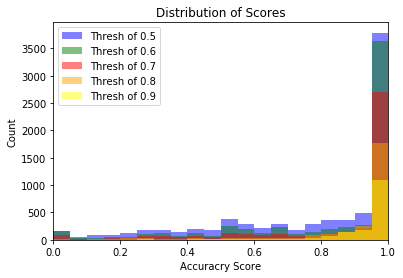

There were 213 sender reciever pair for which no emails were predicted to contain this pairing for 0.5
There were 2706 sender reciever pair for which no emails were predicted to contain this pairing for 0.6
There were 4723 sender reciever pair for which no emails were predicted to contain this pairing for 0.7
There were 4723 sender reciever pair for which no emails were predicted to contain this pairing for 0.8
There were 4723 sender reciever pair for which no emails were predicted to contain this pairing for 0.9


In [11]:
plt.hist(pred_acc_sr_listv05['accuracy'], bins = 20, alpha = 0.5, color = 'blue', label = 'Thresh of 0.5')
plt.hist(pred_acc_sr_listv06['accuracy'], bins = 20, alpha = 0.5, color = 'green', label = 'Thresh of 0.6')
plt.hist(pred_acc_sr_listv07['accuracy'], bins = 20, alpha = 0.5, color = 'red', label = 'Thresh of 0.7')
plt.hist(pred_acc_sr_listv08['accuracy'], bins = 20, alpha = 0.5, color = 'orange', label = 'Thresh of 0.8')
plt.hist(pred_acc_sr_listv09['accuracy'], bins = 20, alpha = 0.5, color = 'yellow', label = 'Thresh of 0.9')
plt.legend()
plt.xlabel('Accuracry Score')
plt.ylabel('Count')
plt.xlim(0,1)
plt.title('Distribution of Scores')
plt.show()
print('There were {} sender reciever pair for which no emails were predicted to contain this pairing for 0.5'.format(len(missed_emails05)))
print('There were {} sender reciever pair for which no emails were predicted to contain this pairing for 0.6'.format(len(missed_emails06)))
print('There were {} sender reciever pair for which no emails were predicted to contain this pairing for 0.7'.format(len(missed_emails07)))
print('There were {} sender reciever pair for which no emails were predicted to contain this pairing for 0.8'.format(len(missed_emails08)))
print('There were {} sender reciever pair for which no emails were predicted to contain this pairing for 0.9'.format(len(missed_emails09)))

# Ranking the attemps by threshold.
The highest rate of accuracy and the lowest amount of zero predicted emails for a pair is clearly at similarity threshold of 0.5.  Lets further analyize the 0.5 threshold data.

In [12]:
perfect_pred_rate = len(pred_acc_sr_listv05[pred_acc_sr_listv05['accuracy'] == 1])
perfect_pred_rate

3708

In [13]:
btr_thn_80 = len(pred_acc_sr_listv05[pred_acc_sr_listv05['accuracy'] > 0.80])
btr_thn_80

4892

In [21]:
total_sr_pairs = len(pred_acc_sr_listv05) + missed_all_emails

rate_perfect_score = btr_thn_80/total_sr_pairs
print('{}% of S_R pairs were accuractely predicted more than 80% of the time.'.format(round(rate_perfect_score, 2)))

rate_perfect_score = perfect_pred_rate/total_sr_pairs
print('{}% of S_R pairs were accuractely predicted more than 100% of the time.'.format(round(rate_perfect_score, 2)))

0.6% of S_R pairs were accuractely predicted more than 80% of the time.
0.45% of S_R pairs were accuractely predicted more than 100% of the time.


# Accuracy of chosen threshold
Overall thats a pretty good accuracy for an unsupervised method.  Its not perfect but impressive still.  Lets take a quick look at the emails themselves and see if there might be a cause to our lack of success with some emails.

In [19]:
missed_emails05.head()

,sender,recipient,addressbooksize,num_emails,accuracy,train_e_cnt,test_e_cnt,num_pred_emails
116,chris.germany@enron.com,jim.homco@enron.com,560,277,NaN,222,55,0
129,matt.motsinger@enron.com,torrey.moorer@enron.com,90,58,NaN,42,16,0
144,cara.semperger@enron.com,diane.cutsforth@enron.com,188,52,NaN,35,17,0
153,kate.symes@enron.com,chris.mallory@enron.com,203,73,NaN,54,19,0
155,kate.symes@enron.com,bill.williams@enron.com,203,108,NaN,87,21,0


In [20]:
test = wanted_emails[(wanted_emails['from']== 'chris.germany@enron.com') & ((wanted_emails['to_all'].str.contains('jim.homco@enron.com')))]['body']
lengths = []
for x in test:
    lengths.append(len(x))
print(np.mean(lengths), np.std(lengths), '\n')
for x in range(10):
    print('*********************** TEST CASE {} ***********************'.format(x+1))
    print(np.random.choice(test))
    

820.238267148 1091.85459135 

*********************** TEST CASE 1 ***********************
I added Meredith's photo to the web page below last night.


---------------------- Forwarded by Chris Germany/HOU/ECT on 09/14/2000 12:17 
PM ---------------------------


Chris Germany
09/11/2000 07:23 AM
To: Steve Gillespie/Corp/Enron@ENRON, Scott Goodell/Corp/Enron@ENRON
cc:  
Subject: Steve Photo's

I have Steve and Lisa on the internet at this web address

http://www.cartogra.com/home/home.asp

Enter the account name "trogg522" in the box on the bottom right.

*********************** TEST CASE 2 ***********************
Currently, we are unable to use IT to serve Ogy at Doyle on Transco.  I have devised a super scientific method for pricing VNG space for Ogy.  Poke all the holes in it you want.

Use the following formulas to determine the price to Ogy

The higher of
St 65 Offer plus $.35
TCO Offer plus $.14

Good Luck
*********************** TEST CASE 3 ***********************
"Moths"

A man 

In [54]:
pred_acc_sr_list[pred_acc_sr_list['accuracy'] == 1].head()

,sender,recipient,addressbooksize,num_emails,accuracy,train_e_cnt,test_e_cnt,num_pred_emails
0,savita.puthigai@enron.com,greg.piper@enron.com,123,71,1.0,58,13,8
3,savita.puthigai@enron.com,leonardo.pacheco@enron.com,123,64,1.0,51,13,10
6,savita.puthigai@enron.com,group.enron@enron.com,123,91,1.0,69,22,20
11,savita.puthigai@enron.com,carl.carter@enron.com,123,62,1.0,49,13,11
13,adam.johnson@enron.com,tammie.schoppe@enron.com,163,75,1.0,57,18,13


In [64]:
test = wanted_emails[(wanted_emails['from'] == 'savita.puthigai@enron.com') & ((wanted_emails['to_all'].str.contains('tammie.schoppe@enron.com')))]['body']
lengths = []
for x in test:
    lengths.append(len(x))
print(np.mean(lengths), np.std(lengths), '\n')

for x in range(10):
    print('*********************** TEST CASE {} ***********************'.format(x+1))
    print(np.random.choice(test))
    

184.0 31.0 

*********************** TEST CASE 1 ***********************
Hi Louise, 

We did not cut off TXU on ICE , TXU cut us off. Also Tom Moran in credit maintains the list of counterparties who can trade on ICE not Stephanie. I will get you the list asof today ASAP. Thnaks.

Savita
*********************** TEST CASE 2 ***********************
Hi Louise, 

We did not cut off TXU on ICE , TXU cut us off. Also Tom Moran in credit maintains the list of counterparties who can trade on ICE not Stephanie. I will get you the list asof today ASAP. Thnaks.

Savita
*********************** TEST CASE 3 ***********************
Hi Louise,

Here is the information you were looking for:

No of external transactions today = 8368
No of external users transacting today = 1376

Savita
*********************** TEST CASE 4 ***********************
Hi Louise,

Here is the information you were looking for:

No of external transactions today = 8368
No of external users transacting today = 1376

Savita
*******

# Email evaluation breakdown
Emails from the the group where no emails were predicted from a sender reciever pair seems to be far less formal.  They contain personal dialogue, jokes, invitation to go drinking, and never include a 'to you' format'.

Emails that were predicted well seems to show a pattern of business formality, frequently discussing similar topics and start the email with a 'Hi X' format

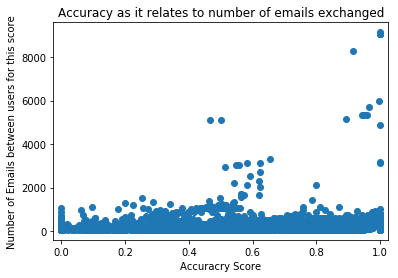

In [24]:
plt.scatter(pred_acc_sr_listv05['accuracy'], pred_acc_sr_listv05['num_emails'])
plt.xlabel('Accuracry Score')
plt.ylabel('Number of Emails between users for this score')
plt.title('Accuracy as it relates to number of emails exchanged')
plt.xlim(-0.025,1.025)
plt.show()

# Accuracy as it relates to number of emails predicted.
It seems that the more emails sent between the pair the more likely they are to have a higher accuracy score

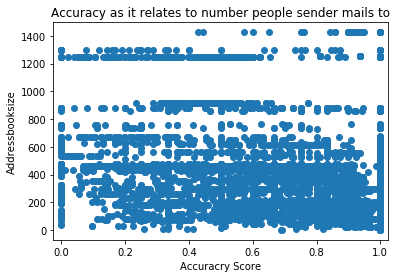

In [25]:
plt.scatter(pred_acc_sr_listv05['accuracy'], pred_acc_sr_listv05['addressbooksize'])
plt.xlabel('Accuracry Score')
plt.ylabel('Addressbooksize')
plt.title('Accuracy as it relates to number people sender mails to')
plt.xlim(-0.025,1.025)
plt.show()

# Accuracy as it relates to address book size
THere seems to be no pattern to accuracy as it relates to the number of people the sender sends emails two

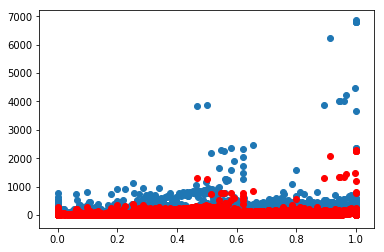

In [26]:
plt.scatter(pred_acc_sr_listv05['accuracy'], pred_acc_sr_listv05['train_e_cnt'])
plt.scatter(pred_acc_sr_listv05['accuracy'], pred_acc_sr_listv05['test_e_cnt'], color = 'red')
plt.show()

# Accuracy as it relates to number of emails in train and test size
The more emails in both train and test the higher the rate of accurate prediction

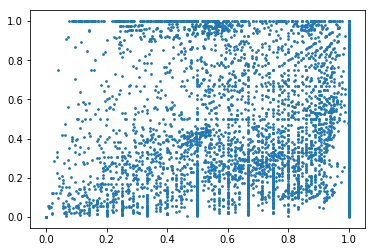

In [14]:
plt.scatter(pred_acc_sr_list['accuracy'], pred_acc_sr_list['num_pred_emails']/pred_acc_sr_list['test_e_cnt'], s = 3)
plt.show()

# Accuracy as it relates to number of predicted emails divided by total size of test email dataset

There is a positive correlation between accuracy and the rate of predicted emails per emails in the test set.  

# Summary of results

This method of predicting recipients for an email based off of the email body seems to be useful in the context where emails are written in a more formal way.  It could be used as a method of reminding people composing emails not to forget anyone but at best having an accuracy of 60% suggests that it would not be reliable as a primary method of determining recipients to an email.